# flight delay predictor for TunisAir

In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import category_encoders as ce
from catboost import CatBoostRegressor, Pool
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

## split dataset into train & test

In [103]:
df = pd.read_csv('./data/Data.csv')

### dropping outliers from main dataset

In [104]:
Q1 = df['target'].quantile(0.25)
Q3 = df['target'].quantile(0.90)
IQR = Q3 - Q1
upper_bound = Q3 + 2.5 * IQR
df['target'] = np.clip(df['target'], 0, upper_bound)

In [105]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=17
)

In [106]:
X_train.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
27598,train_id_27598,2016-09-10,TU 0717,ORY,TUN,2016-09-10 10:15:00,2016-09-10 12.40.00,ATA,TU 32AIMH
98934,train_id_98934,2018-11-30,TU 0634,DJE,ORY,2018-11-30 06:30:00,2018-11-30 09.15.00,ATA,TU 736IOQ
18670,train_id_18670,2016-08-04,UG 1310,TUN,CDG,2016-08-04 18:15:00,2016-08-04 20.30.00,ATA,TU 31BIMO
49984,train_id_49984,2017-10-17,TU 0706,CMN,TUN,2017-10-17 19:35:00,2017-10-17 21.55.00,ATA,TU 320IMV
30122,train_id_30122,2016-06-27,UG 0003,DJE,TUN,2016-06-27 07:45:00,2016-06-27 08.45.00,SCH,UG AT7LBE


In [107]:
df['target'].mean()

np.float64(45.03839269982287)

**the mean delay is about 48.73 minutes**

---
## data cleaning

### convert date formats

In [108]:
X_train['STD'] =  pd.to_datetime(X_train['STD'], format='%Y-%m-%d %H:%M:%S')
X_train['STA'] =  pd.to_datetime(X_train['STA'], format='%Y-%m-%d %H.%M.%S')
X_train['DATOP'] =  pd.to_datetime(X_train['DATOP'], format='%Y-%m-%d')

X_test['STD'] =  pd.to_datetime(X_test['STD'], format='%Y-%m-%d %H:%M:%S')
X_test['STA'] =  pd.to_datetime(X_test['STA'], format='%Y-%m-%d %H.%M.%S')
X_test['DATOP'] =  pd.to_datetime(X_test['DATOP'], format='%Y-%m-%d')

In [109]:
df['STATUS'].unique()

array(['ATA', 'DEP', 'RTR', 'SCH', 'DEL'], dtype=object)

*status column is data leakage so it needs to be dropped*

In [110]:
X_train = X_train.drop('STATUS', axis=1)
X_test = X_test.drop('STATUS', axis=1)

In [111]:
df.isnull().sum(axis=0).reset_index()

,index,0
0,ID,0
1,DATOP,0
2,FLTID,0
3,DEPSTN,0
4,ARRSTN,0
5,STD,0
6,STA,0
7,STATUS,0
8,AC,0
9,target,0


**no missing values in the dataset**

---
## relationship between delay & route (departure -> arrival) 

In [112]:
dep_delay = df.groupby("DEPSTN")["target"].mean().reset_index()
dep_delay = dep_delay.rename(columns={"target": "mean_delay"})

arr_delay = df.groupby("ARRSTN")["target"].mean().reset_index()
arr_delay = arr_delay.rename(columns={"target": "mean_delay"})

print(dep_delay["mean_delay"].describe())
print(arr_delay["mean_delay"].describe())


count    132.000000
mean      51.422574
std       57.810680
min        0.000000
25%       14.609375
50%       44.621185
75%       67.307684
max      358.714286
Name: mean_delay, dtype: float64
count    128.000000
mean      47.019830
std       54.433744
min        0.000000
25%       15.427721
50%       37.722290
75%       59.676910
max      382.000000
Name: mean_delay, dtype: float64


In [113]:
model = ols("target ~ C(DEPSTN)", data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

model2 = ols("target ~ C(ARRSTN)", data=df).fit()
anova_table2 = sm.stats.anova_lm(model2, typ=2)
print(anova_table2)

                 sum_sq        df          F  PR(>F)
C(DEPSTN)  2.621874e+07     131.0  29.013802     0.0
Residual   7.429431e+08  107701.0        NaN     NaN
                 sum_sq        df        F  PR(>F)
C(ARRSTN)  1.485784e+07     127.0  16.7048     0.0
Residual   7.543040e+08  107705.0      NaN     NaN


p-values are both low *(below 0.5)*, therefore the arrival and departure points have an effect on delay

---
## relationship between aircraft usage & delay

In [114]:
ac_usage = df.groupby("AC").size().reset_index(name="flight_count")
ac_delay = df.groupby("AC")["target"].mean().reset_index(name="mean_delay")
ac_stats = ac_usage.merge(ac_delay, on="AC")
print(ac_stats.head())

          AC  flight_count  mean_delay
0  5K 343TQY            54   61.000000
1  5K 345TFX           214  112.962617
2  5M 343FOX            63   48.158730
3  5M 343JAI           129   88.108527
4  5M 343SUN            68  107.808824


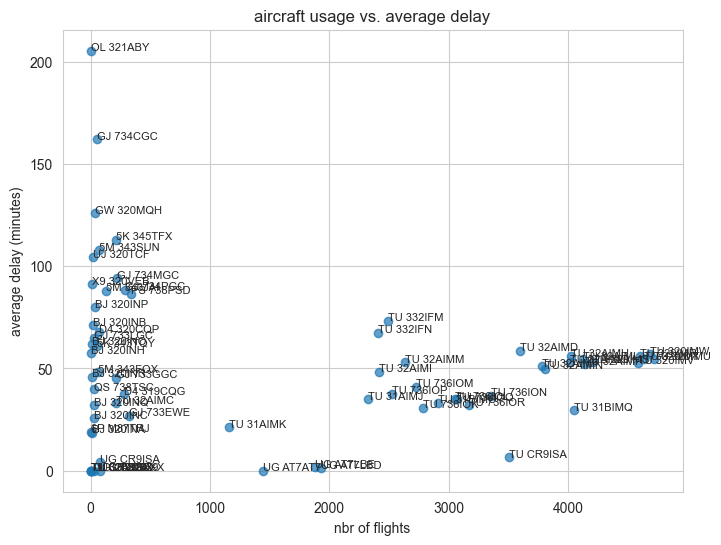

In [115]:
plt.figure(figsize=(8,6))
plt.scatter(ac_stats["flight_count"], ac_stats["mean_delay"], alpha=0.7)

plt.xlabel("nbr of flights")
plt.ylabel("average delay (minutes)")
plt.title("aircraft usage vs. average delay")

# Optional: label some points
for i, row in ac_stats.iterrows():
    plt.text(row["flight_count"], row["mean_delay"], row["AC"], fontsize=8)

plt.show()

+ high usage aircrafts have stable delays *(normal delays)*
+ low usage aircrafts have extreme averages 

In [116]:
ac_stats["flight_count"].corr(ac_stats["mean_delay"])

np.float64(-0.13149956283376193)

-> no correlation between aircraft & delay

---
## relationship between delay & the month

    month     target
0       1  34.481366
1       2  21.942863
2       3  47.158105
3       4  49.265461
4       5  48.137047
5       6  40.509218
6       7  54.532308
7       8  59.727816
8       9  55.643252
9      10  32.743397
10     11  30.321900
11     12  46.767513


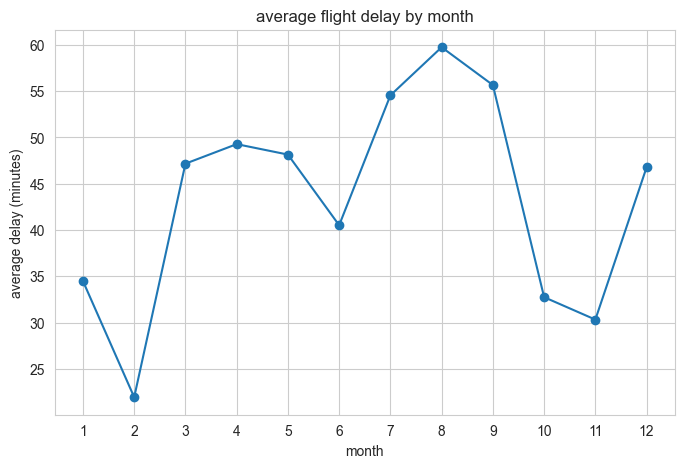

In [117]:
df["month"] = pd.to_datetime(df["DATOP"]).dt.month
month_delay = df.groupby("month")["target"].mean().reset_index()
print(month_delay)

plt.figure(figsize=(8,5))
plt.plot(month_delay["month"], month_delay["target"], marker="o")
plt.xticks(range(1,13))
plt.xlabel("month")
plt.ylabel("average delay (minutes)")
plt.title("average flight delay by month")
plt.grid(True)
plt.show()

+ more delays on summer months (july, august, september)
+ early months (jan, feb) and late fall (oct, nov) show lower delays.

---
## feature engineering

In [118]:
X_train['trajectory'] = X_train['DEPSTN'] + '-' + X_train['ARRSTN']
X_test['trajectory'] = X_test['DEPSTN'] + '-' + X_test['ARRSTN']
X_train['trajectory'].nunique()


722

In [119]:
X_train['month'] = pd.DatetimeIndex(X_train['DATOP']).month.values
X_train['day'] = pd.DatetimeIndex(X_train['DATOP']).day.values
X_train['day_of_week'] = pd.DatetimeIndex(X_train['DATOP']).dayofweek.values
X_train['year'] = pd.DatetimeIndex(X_train['DATOP']).year.values
X_train['week_of_year'] = pd.DatetimeIndex(X_train['DATOP']).isocalendar().week.astype(int).values
X_train['week_of_month'] = ((pd.DatetimeIndex(X_train['DATOP']).day - 1) // 7 + 1).values

In [120]:
X_test['month'] = pd.DatetimeIndex(X_test['DATOP']).month.values
X_test['day'] = pd.DatetimeIndex(X_test['DATOP']).day.values
X_test['day_of_week'] = pd.DatetimeIndex(X_test['DATOP']).dayofweek.values
X_test['year'] = pd.DatetimeIndex(X_test['DATOP']).year.values
X_test['week_of_year'] = pd.DatetimeIndex(X_test['DATOP']).isocalendar().week.astype(int).values
X_test['week_of_month'] = ((pd.DatetimeIndex(X_test['DATOP']).day - 1) // 7 + 1).values

**adding a season for each flight**

In [121]:
def get_season(month):
    if month in [12, 1, 2]:
        return 0 #winter
    elif month in [3, 4, 5]:
        return 1 #spring
    elif month in [6, 7, 8]:
        return 2 #summer
    else:  # 9, 10, 11
        return 3 #fall
    
X_train['season'] = X_train['month'].apply(get_season)
X_test['season'] = X_test['month'].apply(get_season)

In [122]:
X_train['dep_hour'] = pd.DatetimeIndex(X_train['STD']).hour 
X_test['dep_hour'] = pd.DatetimeIndex(X_test['STD']).hour

X_train['arr_hour'] = pd.DatetimeIndex(X_train['STA']).hour 
X_test['arr_hour'] = pd.DatetimeIndex(X_test['STA']).hour

In [123]:
X_train['dep_minute'] = pd.DatetimeIndex(X_train['STD']).minute 
X_test['dep_minute'] = pd.DatetimeIndex(X_test['STD']).minute

X_train['arr_minute'] = pd.DatetimeIndex(X_train['STA']).minute 
X_test['arr_minute'] = pd.DatetimeIndex(X_test['STA']).minute

In [124]:
X_train['flight_duration_sec'] = (X_train['STA'] - X_train['STD']).dt.total_seconds().astype(int)
X_test['flight_duration_sec']  = (X_test['STA'] - X_test['STD']).dt.total_seconds().astype(int)

In [125]:
X_train['flight_duration_hours'] = X_train['arr_hour'] - X_train['dep_hour'] 
X_test['flight_duration_hours'] = X_test['arr_hour'] - X_test['dep_hour']

In [126]:
X_train['flight_duration_min'] = (X_train['flight_duration_sec'] / 60).astype(int)
X_test['flight_duration_min']  = (X_test['flight_duration_sec'] / 60).astype(int)

**arrival hour type (AM/PM)**

In [127]:
data = [X_train, X_test]
for dataset in data:
    dataset.loc[ (dataset['dep_hour'] < 12) , 'dep_hour_AM_PM'] = 0
    dataset.loc[(dataset['dep_hour'] >= 12) , 'dep_hour_AM_PM'] = 1
    dataset['dep_hour_AM_PM'] = dataset['dep_hour_AM_PM'].astype(int)

    dataset.loc[ (dataset['arr_hour'] < 12) , 'arr_hour_AM_PM'] = 0
    dataset.loc[(dataset['arr_hour'] >= 12) , 'arr_hour_AM_PM'] = 1
    dataset['arr_hour_AM_PM'] = dataset['arr_hour_AM_PM'].astype(int)

In [128]:
X_train['S_dep_hour'] = np.sin(2*np.pi*X_train['dep_hour']/24)
X_train['C_dep_hour'] = np.cos(2*np.pi*X_train['dep_hour']/24)
X_test['S_dep_hour'] = np.sin(2*np.pi*X_test['dep_hour']/24)
X_test['C_dep_hour'] = np.cos(2*np.pi*X_test['dep_hour']/24)

X_train['S_arr_hour'] = np.sin(2*np.pi*X_train['arr_hour']/24)
X_train['C_arr_hour'] = np.cos(2*np.pi*X_train['arr_hour']/24)
X_test['S_arr_hour'] = np.sin(2*np.pi*X_test['arr_hour']/24)
X_test['C_arr_hour'] = np.cos(2*np.pi*X_test['arr_hour']/24)

In [129]:
data = [X_train, X_test]

for dataset in data:
    for i in range(dataset.shape[0]):
        dataset.loc[dataset.index[i], 'day_of_year'] = int(dataset.iloc[i]['DATOP'].strftime('%j'))


**frequency of aircraft usage**

In [130]:
aircraft_counts = df['AC'].value_counts()
def categorize_usage(ac):
    count = aircraft_counts.get(ac, 0)  # get number of flights for this AC
    if count < 100:
        return 'low'
    elif 100 <= count <= 200:
        return 'medium'
    else:
        return 'high'

X_train['AC_usage'] = X_train['AC'].apply(categorize_usage)
X_test['AC_usage'] = X_test['AC'].apply(categorize_usage)

X_train = pd.get_dummies(X_train, columns=['AC_usage'])
X_test = pd.get_dummies(X_test, columns=['AC_usage'])

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

**encoding categorical variables**

In [131]:
datetime_cols = ['DATOP', 'STD', 'STA']
for col in datetime_cols:
    X_train[col + '_year'] = X_train[col].dt.year
    X_train[col + '_month'] = X_train[col].dt.month
    X_train[col + '_day'] = X_train[col].dt.day
    X_train[col + '_hour'] = X_train[col].dt.hour
    X_train.drop(col, axis=1, inplace=True)
    
    X_test[col + '_year'] = X_test[col].dt.year
    X_test[col + '_month'] = X_test[col].dt.month
    X_test[col + '_day'] = X_test[col].dt.day
    X_test[col + '_hour'] = X_test[col].dt.hour
    X_test.drop(col, axis=1, inplace=True)

In [132]:
categorical_cols = ['AC', 'DEPSTN', 'ARRSTN', 'season']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols].astype(str))
X_test[categorical_cols]  = encoder.transform(X_test[categorical_cols].astype(str))

In [133]:
te = ce.TargetEncoder(cols=['trajectory','FLTID'])
X_train = te.fit_transform(X_train, y_train)
X_test  = te.transform(X_test)

In [134]:
X_train = X_train.drop('ID', axis=1)
X_test = X_test.drop('ID', axis=1)

In [135]:
X_train.head()

,FLTID,DEPSTN,ARRSTN,AC,trajectory,month,day,day_of_week,year,week_of_year,...,DATOP_day,DATOP_hour,STD_year,STD_month,STD_day,STD_hour,STA_year,STA_month,STA_day,STA_hour
27598,39.839465,94.0,116.0,41.0,52.812076,9,10,5,2016,36,...,10,0,2016,9,10,10,2016,9,10,12
98934,24.068607,36.0,91.0,54.0,32.441646,11,30,4,2018,48,...,30,0,2018,11,30,6,2018,11,30,9
18670,13.008597,120.0,28.0,28.0,82.166667,8,4,3,2016,31,...,4,0,2016,8,4,18,2016,8,4,20
49984,109.060510,30.0,116.0,34.0,46.254457,10,17,1,2017,42,...,17,0,2017,10,17,19,2017,10,17,21
30122,1.250298,36.0,116.0,61.0,9.402131,6,27,0,2016,26,...,27,0,2016,6,27,7,2016,6,27,8


In [136]:
X_test.head()

,FLTID,DEPSTN,ARRSTN,AC,trajectory,month,day,day_of_week,year,week_of_year,...,DATOP_day,DATOP_hour,STD_year,STD_month,STD_day,STD_hour,STA_year,STA_month,STA_day,STA_hour
69632,2.486726,85.0,116.0,57.0,1.351111,12,11,0,2017,50,...,11,0,2017,12,11,12,2017,12,11,13
88753,24.068607,36.0,113.0,40.0,28.111140,5,8,1,2018,19,...,8,0,2018,5,8,4,2018,5,8,5
3041,26.471719,120.0,48.0,42.0,26.006928,6,19,6,2016,24,...,19,0,2016,6,19,6,2016,6,19,9
84105,61.913082,20.0,76.0,39.0,48.257927,8,21,1,2018,34,...,21,0,2018,8,21,20,2018,8,21,23
1829,80.358025,94.0,116.0,30.0,52.812076,8,21,6,2016,33,...,21,0,2016,8,21,12,2016,8,21,15


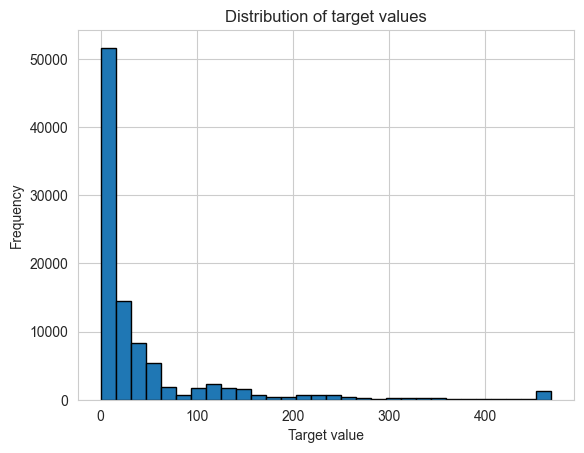

In [137]:
plt.hist(y_train, bins=30, edgecolor="black")
plt.title("Distribution of target values")
plt.xlabel("Target value")
plt.ylabel("Frequency")
plt.show()

**target values are skewed to the edges** \
we can log the target y-values for better output

In [138]:
y_test = np.log1p(y_test)
y_train = np.log1p(y_train)

## stage 1: classification

### binary target

In [139]:
y_test_class = (y_test > 0).astype(int)
y_train_class = (y_train > 0).astype(int)

### classifier model

In [140]:
clf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    random_state=42,
    class_weight='balanced'
)
clf_model.fit(X_train, y_train_class)

,n_estimators,200
,criterion,'gini'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [141]:
y_pred_proba = clf_model.predict_proba(X_test)[:, 1]
y_pred_class = clf_model.predict(X_test)

**evaluating classifier**

In [142]:
print("Classification Performance:")
print(classification_report(y_test_class, y_pred_class))
print(f"ROC AUC: {roc_auc_score(y_test_class, y_pred_proba):.4f}")

Classification Performance:
              precision    recall  f1-score   support

           0       0.74      0.64      0.69      3884
           1       0.81      0.87      0.84      6900

    accuracy                           0.79     10784
   macro avg       0.78      0.76      0.76     10784
weighted avg       0.79      0.79      0.79     10784

ROC AUC: 0.8430


## stage 2: regression

### XGBoost

In [148]:
#filtering data to only include delayed flights
delay_mask_train = y_train > 0
delay_mask_test = y_test > 0

X_train_delayed = X_train[delay_mask_train]
y_train_delayed = y_train[delay_mask_train]

X_test_delayed = X_test[delay_mask_test]
y_test_delayed = y_test[delay_mask_test]

model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,  
    max_depth=4,         
    min_child_weight=10, 
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1,         
    reg_lambda=1,       
    random_state=42
)

sample_weight = np.where(y_train_delayed > 60, 2, 1)

model.fit(X_train_delayed, y_train_delayed, sample_weight=sample_weight)

y_pred_log = model.predict(X_test_delayed)
y_pred_minutes = np.expm1(y_pred_log)
y_test_minutes = np.expm1(y_test_delayed)

mse = mean_squared_error(y_test_minutes, y_pred_minutes)
rmse = mse ** 0.5
print(f"Test RMSE: {rmse}")

mae  = mean_absolute_error(y_test_minutes, y_pred_minutes)
print("MAE:", mae)

Test RMSE: 96.34999094321479
MAE: 50.158267024772755


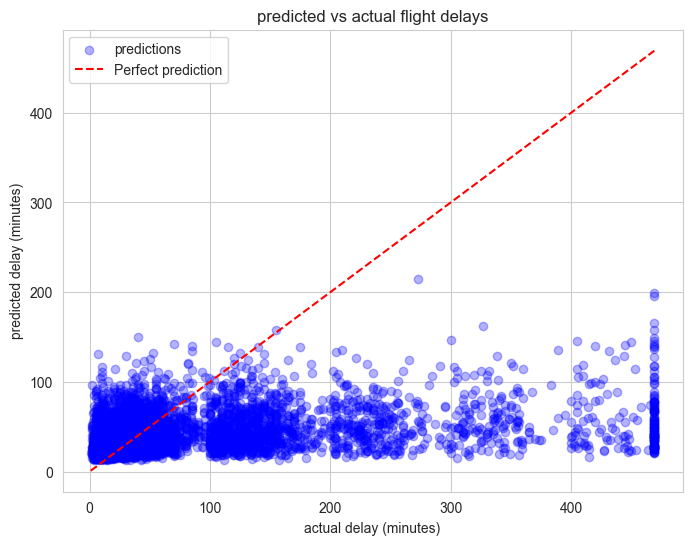

In [149]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test_minutes, y_pred_minutes, alpha=0.3, color="blue", label="predictions")

lims = [min(min(y_test_minutes), min( y_pred_minutes)), max(max(y_test_minutes), max( y_pred_minutes))]
plt.plot(lims, lims, 'r--', label="Perfect prediction")

plt.xlabel("actual delay (minutes)")
plt.ylabel("predicted delay (minutes)")
plt.title("predicted vs actual flight delays")
plt.legend()
plt.grid(True)
plt.show()

### residual analysis

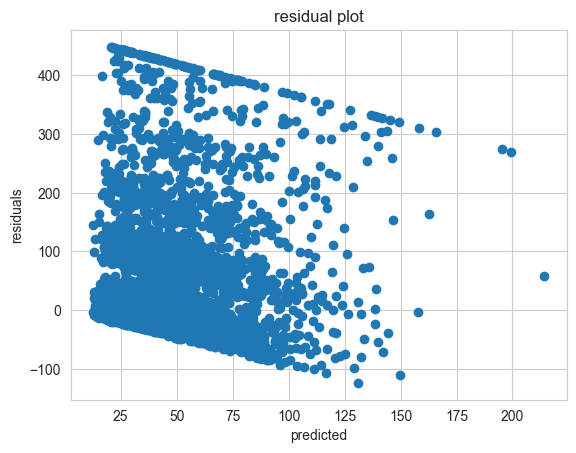

In [150]:
residuals = y_test_minutes - y_pred_minutes
plt.scatter(y_pred_minutes, residuals)
plt.xlabel('predicted')
plt.ylabel('residuals')
plt.title('residual plot')
plt.show()

## catboost

In [151]:
categorical_cols = ['FLTID','AC','trajectory','DEPSTN','ARRSTN','season']

for col in categorical_cols:
    X_train_delayed[col] = X_train_delayed[col].astype(str)
    X_test_delayed[col]  = X_test_delayed[col].astype(str)

weights = np.where((y_train_delayed >= 40) & (y_train_delayed <= 140), 3, 1)

train_pool = Pool(X_train_delayed, y_train_delayed, cat_features=categorical_cols, weight=weights)
test_pool  = Pool(X_test_delayed,  y_test_delayed,  cat_features=categorical_cols)

cb = CatBoostRegressor(iterations=2000, depth=6, learning_rate=0.03, loss_function="RMSE", random_seed=42, early_stopping_rounds=100,verbose=200)
cb.fit(train_pool, eval_set=test_pool)

y_pred = cb.predict(test_pool)


mse = mean_squared_error(y_test_delayed, y_pred)
rmse = mse ** 0.5
print(f"Test RMSE: {rmse}")

mae  = mean_absolute_error(y_test_delayed, y_pred)
print("MAE:", mae)

C:\Users\Dell\AppData\Local\Temp\ipykernel_17660\2311033686.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_delayed[col] = X_train_delayed[col].astype(str)
C:\Users\Dell\AppData\Local\Temp\ipykernel_17660\2311033686.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_delayed[col]  = X_test_delayed[col].astype(str)
C:\Users\Dell\AppData\Local\Temp\ipykernel_17660\2311033686.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

0:	learn: 1.1191632	test: 1.1280614	best: 1.1280614 (0)	total: 57.9ms	remaining: 1m 55s
200:	learn: 1.0122967	test: 1.0244924	best: 1.0244924 (200)	total: 13.1s	remaining: 1m 57s
400:	learn: 0.9943722	test: 1.0111801	best: 1.0111801 (400)	total: 27s	remaining: 1m 47s
600:	learn: 0.9821255	test: 1.0026531	best: 1.0026531 (600)	total: 40.6s	remaining: 1m 34s
800:	learn: 0.9728984	test: 0.9968585	best: 0.9968585 (800)	total: 54.2s	remaining: 1m 21s
1000:	learn: 0.9658222	test: 0.9930741	best: 0.9930741 (1000)	total: 1m 8s	remaining: 1m 7s
1200:	learn: 0.9597110	test: 0.9900688	best: 0.9900688 (1200)	total: 1m 21s	remaining: 54.4s
1400:	learn: 0.9540083	test: 0.9879411	best: 0.9879411 (1400)	total: 1m 35s	remaining: 40.8s
1600:	learn: 0.9492092	test: 0.9858673	best: 0.9858644 (1594)	total: 1m 49s	remaining: 27.2s
1800:	learn: 0.9449052	test: 0.9845280	best: 0.9845280 (1800)	total: 2m 2s	remaining: 13.6s
1999:	learn: 0.9404808	test: 0.9828481	best: 0.9828457 (1998)	total: 2m 16s	remaining: 

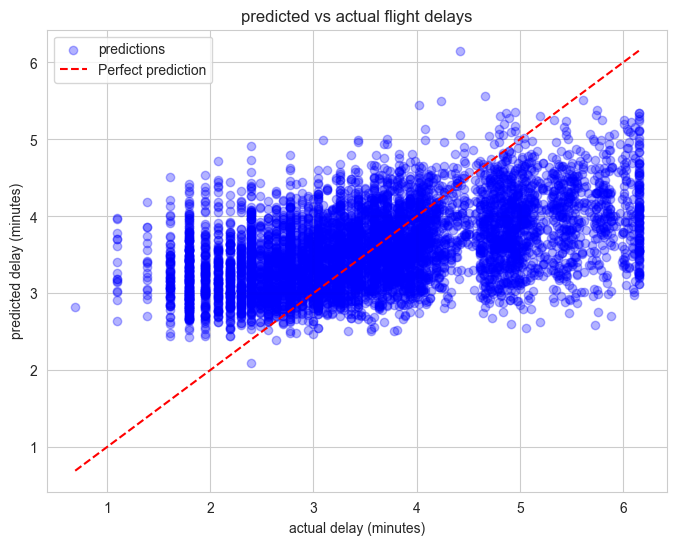

In [152]:
plt.figure(figsize=(8, 6))

plt.scatter(y_test_delayed, y_pred, alpha=0.3, color="blue", label="predictions")

lims = [min(min(y_test_delayed), min( y_pred)), max(max(y_test_delayed), max( y_pred))]
plt.plot(lims, lims, 'r--', label="Perfect prediction")

plt.xlabel("actual delay (minutes)")
plt.ylabel("predicted delay (minutes)")
plt.title("predicted vs actual flight delays")
plt.legend()
plt.grid(True)
plt.show()

### residual analysis

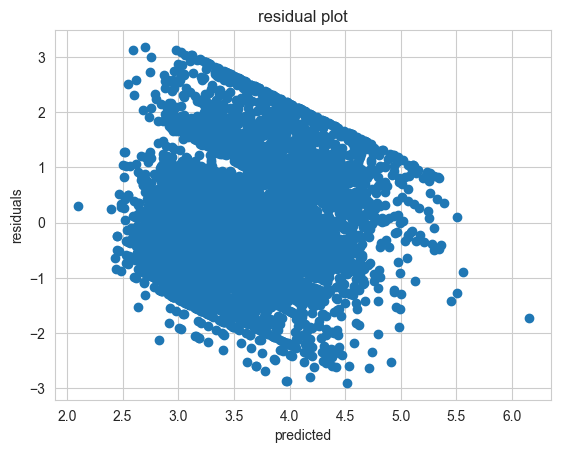

In [153]:
residuals = y_test_delayed - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('predicted')
plt.ylabel('residuals')
plt.title('residual plot')
plt.show()

Top 10 features: [('FLTID', np.float32(0.117665574)), ('S_dep_hour', np.float32(0.08228903)), ('STD_year', np.float32(0.06681016)), ('DATOP_year', np.float32(0.063033596)), ('year', np.float32(0.050057787)), ('STA_month', np.float32(0.045746677)), ('week_of_year', np.float32(0.036941137)), ('STD_month', np.float32(0.035462134)), ('DATOP_month', np.float32(0.0347023)), ('day_of_year', np.float32(0.03373233))]


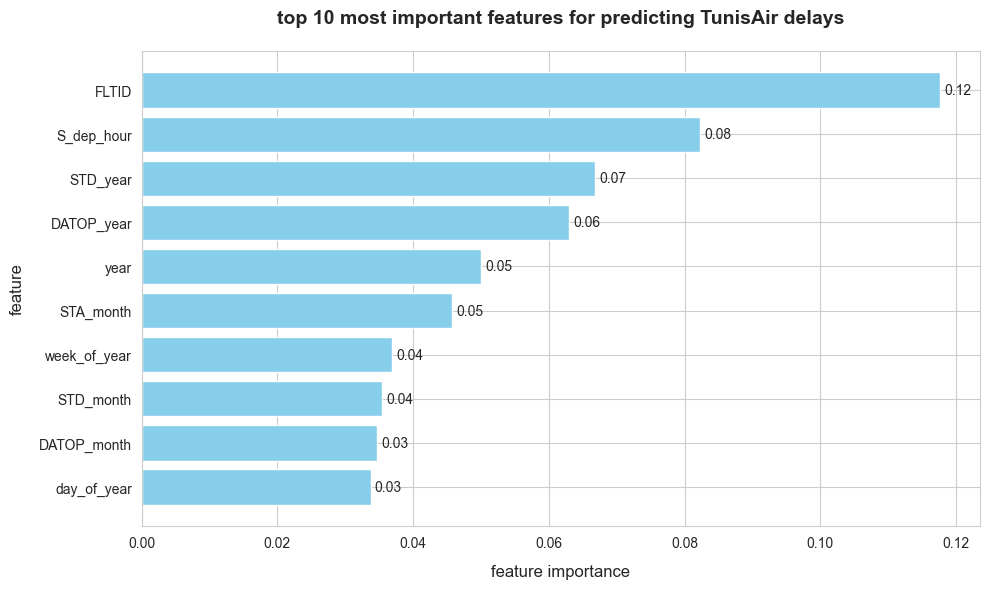

In [ ]:
feature_importance = model.feature_importances_
important_features = sorted(zip(X_train_delayed.columns, feature_importance), 
                           key=lambda x: x[1], reverse=True)
print("Top 10 features:", important_features[:10])

top_features = important_features[:10]

df_imp = pd.DataFrame(top_features, columns=['feature', 'importance'])
df_imp = df_imp.sort_values(by='importance', ascending=True)

#plot
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))

bars = plt.barh(df_imp['feature'], df_imp['importance'], color='skyblue')

plt.xlabel('feature importance', fontsize=12, labelpad=10)
plt.ylabel('feature', fontsize=12, labelpad=10)
plt.title('top 10 most important features for predicting TunisAir delays', 
          fontsize=14, pad=20, fontweight='bold')

for bar in bars:
    width = bar.get_width()
    plt.text(width + max(df_imp['importance'])*0.005,
             bar.get_y() + bar.get_height()/2,
             f'{width:.2f}',
             ha='left', va='center', fontsize=10)

plt.tight_layout()

plt.show()